---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: takachanbo@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import jax
import jax.numpy as jnp

In [2]:
import autoroot
import typing as tp
import equinox as eqx 
from fieldx._src.domain.domain import Domain
import einops

import math
import diffrax as dfx
from jaxtyping import Array, Float
# import jax
import numpy as np
import xarray as xr
import jax.scipy as jsp
from jax.config import config
import pandas as pd
from finitevolx import laplacian, divergence, geostrophic_gradient, x_avg_2D, y_avg_2D, center_avg_2D, MaskGrid, reconstruct
from somax._src.operators.dst import (
    helmholtz_dst, laplacian_dst, inverse_elliptic_dst, inverse_elliptic_dst_cmm, compute_capacitance_matrices
)
from somax._src.models.qg.params import QGParams
from somax._src.models.qg.domain import LayerDomain
from somax._src.models.qg.elliptical import DSTSolution, calculate_helmholtz_dst, compute_homogeneous_solution

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_3687189/1599159505.py:14: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [3]:
sdir = '/nexsan/people/tuchida/somax/'

#### Plot Utils

In [4]:
from loguru import logger


def plot_field(field, name=""):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(9, 3))
    vmin, vmax = np.min(field), np.max(field)
    vlim = np.min([np.abs(vmin), np.abs(vmax)])
    fig.suptitle(name)
    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i].T, cmap="coolwarm", 
                               vmin=-vlim, vmax=vlim, rasterized=True
                              )
        plt.colorbar(pts, shrink=.6)
        ax[i].set_aspect('equal')

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = jnp.min(quantity)
    max_ = jnp.max(quantity)
    mean_ = jnp.mean(quantity)
    median_ = jnp.mean(quantity)
    jax.debug.print(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In [5]:
# # Low Resolution (Non-Resolving)
# Nx, Ny = 64, 64
# Low Resolution (Non-Resolving)
# Nx, Ny = 128, 128
# Low Resolution
# Nx, Ny = 256, 256
# High Resolution
Nx, Ny = 513, 513
# Nx, Ny = 769, 961
# Nx, Ny = 1024, 1024

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 4000e3, 4000e3

dx, dy = Lx / (Nx-1), Ly / (Ny-1)

xy_domain = Domain(
    xmin=(0.0, 0.0), 
    xmax=(Lx, Ly),
    Lx=(Lx, Ly),
    Nx=(Nx, Ny), 
    dx=(dx, dy)
)

# params = QGParams(y0=0.5 * Ly, a_2=20., f0=9.4e-05, beta=1.7e-11, tau0=5e-5, method='wenoz', num_pts=5)
params = QGParams(y0=0.5 * Ly, a_2=35., f0=9.4e-05, beta=1.7e-11, tau0=5e-5, method='linear', num_pts=5)
# params = QGParams(y0=0.5 * Ly, a_2=45., f0=9.4e-05, beta=1.7e-11, tau0=5e-5, method='arakawa', num_pts=5)
params

QGParams(
  f0=9.4e-05,
  beta=1.7e-11,
  tau0=5e-05,
  y0=2000000.0,
  a_2=35.0,
  a_4=0.0,
  bcco=0.2,
  delta_ek=2.0,
  num_pts=5,
  method='linear'
)

In [6]:
xy_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(4000000.0, 4000000.0),
  dx=(7812.5, 7812.5),
  Nx=(513, 513),
  Lx=(4000000.0, 4000000.0),
  ndim=2
)

In [7]:
plt.pcolormesh(xy_domain.grid_axis[-1].T - y0)
plt.colorbar()

NameError: name 'y0' is not defined

In [ ]:
y_coords_center = center_avg_2D(xy_domain.grid_axis[-1])
# print(y_coords_center.mean())
# y_coords_center -= y_coords_center.mean()
# Ly_copy = y_coords_center.max() - y_coords_center.min()

# calculate tau
# analytical form! =]
curl_tau = jnp.sin(2 * math.pi * (y_coords_center) / xy_domain.Lx[-1])
plt.pcolormesh(curl_tau.T, cmap='RdBu_r')
plt.colorbar()
plt.show()
# y0 = 2_000e3
curl_tau = -jnp.sin(2 * math.pi * (y_coords_center-params.y0) / xy_domain.Lx[-1])
# curl_tau -= curl_tau.mean()
plt.pcolormesh(curl_tau.T, cmap='RdBu_r')
plt.colorbar()
plt.show()

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0

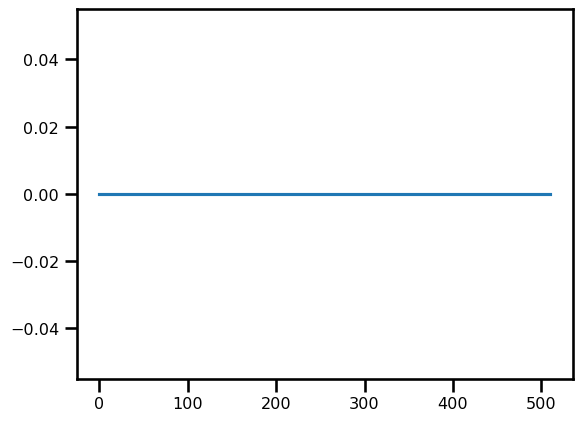

In [69]:
# plt.plot(curl_tau.T[254])
print(curl_tau.T[255])
plt.plot(curl_tau.T[255])
# plt.plot(curl_tau.T[256])

In [7]:
# # octogonal domain
# domain_type = "octogonal"
# mask = np.ones((Nx-1,Ny-1))
# for i in range(Nx//4):
#     for j in range(Ny//4):
#         if i+j < min(Nx//4, Ny//4):
#             mask[i,j] = 0.
#             mask[i,-1-j] = 0.
#             mask[-1-i,j] = 0.
#             mask[-1-i,-1-j] = 0.
            
# masks = MaskGrid.init_mask(mask, location="center")

domain_type = "rectangular"

mask = jnp.ones((Nx,Ny))
mask = mask.at[0].set(0.0)
mask = mask.at[-1].set(0.0)
mask = mask.at[:,0].set(0.0)
mask = mask.at[:,-1].set(0.0)
masks = MaskGrid.init_mask(mask, location="node")


### Layer domain

In [8]:
# heights
heights = [350.0, 750.0, 2900.0]
# heights = [400.0, 1_100.0, 2_600.0]

# reduced gravities
N2 = [4.54545455e-05, 6.84931507e-06]
# reduced_gravities = [0.025, 0.0125]
reduced_gravities = list(np.asarray(N2) 
                         * .5*(np.asarray(heights[1:])+np.asarray(heights[:-1]))
                        )
print(reduced_gravities)

# initialize layer domain
with jax.default_device(jax.devices("cpu")[0]):
    layer_domain = LayerDomain(heights, reduced_gravities, correction=False)

[0.025000000025, 0.012500000002749999]


### Helmoltz

In [9]:
# from jaxsw._src.operators.functional import elliptical as F_elliptical
H_mat = calculate_helmholtz_dst(xy_domain, layer_domain, params)

H_mat.shape

(3, 511, 511)

### Homogeneous Solution

In [10]:
psi0 = jnp.ones(shape=(layer_domain.Nz,) + xy_domain.Nx)

# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_360d.npy")[0]
lambda_sq = params.f0**2 *einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")

homsol = compute_homogeneous_solution(
    psi0, 
    lambda_sq=lambda_sq,
    H_mat=H_mat
)
print_debug_quantity(homsol, "HOMSOL")

# calculate homogeneous solution
homsol_i = jax.vmap(center_avg_2D)(homsol) * masks.center.values

homsol_mean = einops.reduce(homsol_i, "Nz Nx Ny -> Nz 1 1", reduction="mean")
print_debug_quantity(homsol_mean, "HOMSOL MEAN")

# CALCULATE CAPCITANCE MATRIX
if domain_type == "octogonal":
    cap_matrices = compute_capacitance_matrices(
        H_mat, 
        masks.node.irrbound_xids,
        masks.node.irrbound_yids
    )
else:
    cap_matrices = None


# DST SOLUTION
dst_sol = DSTSolution(
    homsol=homsol, 
    homsol_mean=homsol_mean, 
    H_mat=H_mat,
    capacitance_matrix=cap_matrices
)

HOMSOL: (3, 513, 513) | -2.220446e-16 | 3.562978e-01 | 3.562978e-01 | 1.000000e+00
HOMSOL MEAN: (3, 1, 1) | 2.245008e-02 | 3.537809e-01 | 3.537809e-01 | 1.000000e+00


### Custom Forcing

In [11]:
from somax._src.models.qg.forcing import calculate_bottom_drag, calculate_wind_forcing

In [12]:
# import math
# def calculate_wind_forcing(
#     domain: Domain,
#     H_0: float,
#     tau0: float = 5e-5,
# ) -> Float[Array, "Nx Ny"]:
#     """
#     Equation:
#         F_wind: (τ₀ /H₀)(∂xτ−∂yτ)
#     """

#     Ly = domain.Lx[-1]

#     # [Nx,Ny]
#     y_coords = domain.grid_axis[-1]

#     # center coordinates, cell centers
#     # [Nx,Ny] --> [Nx-1,Ny-1]
#     y_coords_center = center_avg_2D(y_coords)

#     # calculate tau
#     # analytical form! =]
#     # curl_tau = -tau0 * 2 * math.pi / Ly * jnp.sin(2 * math.pi * y_coords_center / Ly)
#     curl_tau = - tau0 * 2.*math.pi/Ly * jnp.sin(2*math.pi*y_coords_center/Ly)
    
#     # print_debug_quantity(curl_tau, "CURL TAU")

#     wind_forcing = curl_tau / H_0

#     return wind_forcing

In [12]:
wind_forcing = calculate_wind_forcing(
    domain=xy_domain,
    params=params,
    H_0=layer_domain.heights[0],
    tau0=params.tau0,
)


def forcing_fn(
    psi: Float[Array, "Nz Nx Ny"],
    dq: Float[Array, "Nz Nx-1 Ny-1"],
    domain: Domain,
    layer_domain: LayerDomain,
    params: QGParams,
    masks: MaskGrid,
) -> Float[Array, "Nz Nx Ny"]:
    
    # add wind forcing
    dq = dq.at[0].add(wind_forcing)
    
    # calculate bottom drag
    bottom_drag = calculate_bottom_drag(
        psi=psi, domain=domain,
        H_z=layer_domain.heights[-1],
        delta_ek=params.delta_ek,
        f0=params.f0,
        masks_psi=masks.node
    )
    

    dq = dq.at[-1].add(bottom_drag)
    
    return dq
    

### Initial Quantities

In [13]:
from somax._src.models.qg.operators import (
    calculate_potential_vorticity,
    calculate_psi_from_pv,
    equation_of_motion
)

In [14]:
# PV
q0 = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

In [16]:
dq = equation_of_motion(
    q=q0, psi=psi0, params=params,
    domain=xy_domain, layer_domain=layer_domain,
    forcing_fn=forcing_fn,
    masks=masks
)

dpsi = calculate_psi_from_pv(
    q=dq,
    layer_domain=layer_domain,
    mask_node=masks.node,
    dst_sol=dst_sol
)

## Equation of Motion

In [15]:
class State(eqx.Module):
    q: Array
    psi: Array

In [16]:
def vector_field(t: float, state: State, args) -> State:
    
    dq = equation_of_motion(
        q=state.q, 
        psi=state.psi, 
        params=params,
        domain=xy_domain, 
        layer_domain=layer_domain,
        forcing_fn=forcing_fn,
        masks=masks
    )

    dpsi = calculate_psi_from_pv(
        q=dq,
        params=params,
        domain=xy_domain,
        layer_domain=layer_domain,
        mask_node=masks.node,
        dst_sol=dst_sol,
        remove_beta=False
    )
    
    state = eqx.tree_at(lambda x: x.q, state, dq)
    state = eqx.tree_at(lambda x: x.psi, state, dpsi)
    
    return state

## Time Stepping

About 150 years

In [17]:
# dt = 1_000
# dt = 1e2
dt = 1e-6

tmin = 0.0
num_days = 360*150 # 360 # # 50 # 180 # 30 # 60 #
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()
num_save = 50

In [18]:
from fieldx._src.domain.time import TimeDomain

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [19]:
# Euler, Constant StepSize
# solver = dfx.Euler()
# solver = dfx.Heun()
solver = dfx.Bosh3()
# solver = dfx.Tsit5()
# solver = dfx.Dopri5()

# Tolerances
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
# stepsize_controller = dfx.ConstantStepSize()

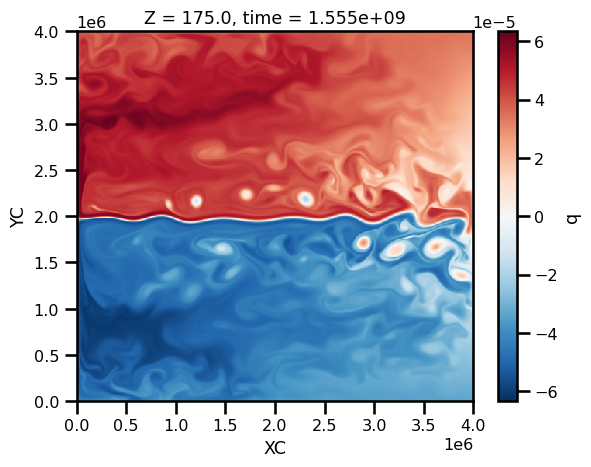

In [20]:
# psi0 *= 0.
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_0.986y_360.00d_octogonal.npy")
import os.path as op
nt = 0
ds = xr.open_zarr(op.join(sdir,
                    'double-gyre/RUNS/spinup/rectangular/N%04d_nu%02d_linear5pt_bosh3/%03d.zarr'
                          % (xy_domain.Nx[0], params.a_2, nt)
                         ))
# ds = xr.open_zarr(op.join(sdir,
#                     'double-gyre/RUNS/spinup/rectangular/N%04d_nu%02d_arakawa_bosh3/%03d.zarr'
#                           % (xy_domain.Nx[0], params.a_2,nt)
#                          ))
# ds = xr.open_zarr(op.join(sdir,
#                     'double-gyre/RUNS/rectangular/N%04d_nu%02d_wenoz5pt_bosh3/%03d.zarr'
#                           % (xy_domain.Nx[0], params.a_2, nt)
#                          ))
# ds = xr.open_zarr(op.join(sdir,
#                     'double-gyre/RUNS/rectangular/N%04d_nu%02d_arakawa_bosh3/%03d.zarr'
#                           % (xy_domain.Nx[0], params.a_2, nt)
#                          ))
psi0 = jnp.asarray(ds.psi.isel(time=-1).data)

# q0 = calculate_potential_vorticity(
#     psi0, xy_domain, layer_domain, 
#     params=params,
#     masks_psi=masks.node, 
#     masks_q=masks.center
# )
ds.q.isel(time=-1,Z=0).T.plot()
q0 = jnp.asarray(ds.q.isel(time=-1).data)

state_init = State(q=q0, psi=psi0)

In [21]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 1h 32min 13s, sys: 5.29 s, total: 1h 32min 18s
Wall time: 1h 32min 41s


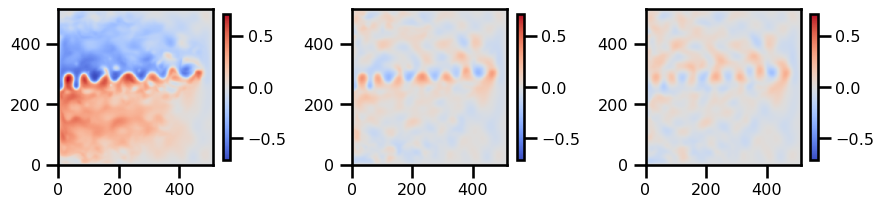

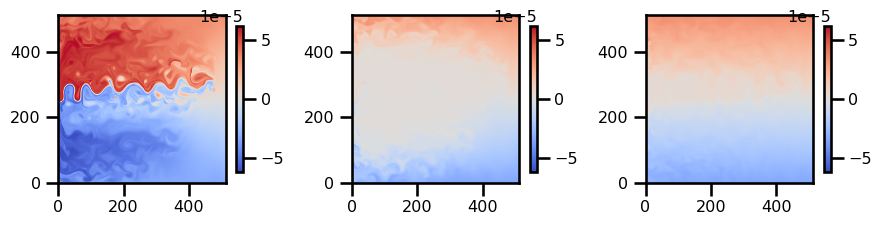

In [22]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])

In [23]:
dZ = np.array([layer_domain.heights[0]*.5, 
               (layer_domain.heights[0]+layer_domain.heights[1])*.5,
               (layer_domain.heights[1]+layer_domain.heights[2])*.5])
Z = np.cumsum(dZ)
Z

array([ 175.,  725., 2550.])

In [24]:
import xarray as xr
import os.path as op

dsave = xr.DataArray(sol.ys.q, dims=['time','Z','XC','YC'],
                     coords={'time':np.arange(360*(150*(nt)+50+3)*86400,
                                              360*(150*(nt+1)+50+3)*86400,
                                              360*3*86400), 
                             'Z':Z, 
                             'YC':np.arange(xy_domain.dx[1]*.5, xy_domain.Lx[1], 
                                            xy_domain.dx[1]),
                             'XC':np.arange(xy_domain.dx[0]*.5, xy_domain.Lx[0], 
                                            xy_domain.dx[0])}
                    ).to_dataset(name='q')
dsave['psi'] = xr.DataArray(sol.ys.psi, dims=['time','Z','Xp1','Yp1'],
                            coords={'time':np.arange(360*(150*(nt)+50+3)*86400,
                                                     360*(150*(nt+1)+50+3)*86400,
                                                     360*3*86400), 
                                    'Z':Z, 
                                    'Yp1':np.arange(0., xy_domain.Lx[1]+xy_domain.dx[1], 
                                                    xy_domain.dx[1]),
                                    'Xp1':np.arange(0., xy_domain.Lx[0]+xy_domain.dx[0], 
                                                    xy_domain.dx[0])}
                           )
dsave.chunk({'time':10,'Z':1}).to_zarr(op.join(sdir,
                            'double-gyre/RUNS/rectangular/N%04d_nu%02d_linear5pt_bosh3/%03d.zarr'
                                               % (xy_domain.Nx[0], params.a_2, nt)
                                              ), mode='w'
                                      )
dsave

<xarray.Dataset>
Dimensions:  (time: 50, Z: 3, YC: 512, XC: 512, Yp1: 513, Xp1: 513)
Coordinates:
  * time     (time) int64 1648512000 1741824000 ... 6127488000 6220800000
  * Z        (Z) float64 175.0 725.0 2.55e+03
  * YC       (YC) float64 3.906e+03 1.172e+04 1.953e+04 ... 3.988e+06 3.996e+06
  * XC       (XC) float64 3.906e+03 1.172e+04 1.953e+04 ... 3.988e+06 3.996e+06
  * Yp1      (Yp1) float64 0.0 7.812e+03 1.562e+04 ... 3.984e+06 3.992e+06 4e+06
  * Xp1      (Xp1) float64 0.0 7.812e+03 1.562e+04 ... 3.984e+06 3.992e+06 4e+06
Data variables:
    q        (time, Z, XC, YC) float64 -3.515e-05 -3.546e-05 ... 3.141e-05
    psi      (time, Z, Xp1, Yp1) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0